# Práctica 5 : Regresión lineal regularizada: sesgo y varianza
#### Realizado por Javier Gómez Moraleda y Unai Piris Ibañez

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
# Cargamos el fichero de datos
data = loadmat('data/ex5data1.mat')

# Datos de entrenamiento (12, 1)
X = data['X']
y = data['y'].ravel()

# Ejemplos de validación (21, 1)
Xval = data['Xval'] 
yval = data['yval'].ravel()

# Ejemplos de prueba (21, 1)
Xtest = data['Xtest']
ytest = data['ytest'].ravel()

## Parte 1 - Regresión lineal regularizada

In [3]:
# Cálculo del coste regularizado
def cost_reg(Thetas, X, y, lam):
    
    # Número de filas
    m = np.shape(X)[0]
    
    # Hipótesis
    H = np.dot(X, Thetas)
    
    # Coste + regularización
    Term1 = (1 / (2*m)) * np.sum(np.square((H - y)))
    Term2 = (lam / (2*m)) * np.sum(np.square(Thetas[1:]))
    
    return Term1 + Term2

In [4]:
# Calcula el gradiente regularizado
def gradient_reg(Thetas, X, y, lam):
    
    # Número de filas
    m = np.shape(X)[0]

    # Hipótesis
    H = np.dot(X, Thetas)
    
    # Gradiente + regularización
    result = (1 / m) * np.matmul(H - y, X)
    result[1:] += (lam / (m)) * np.sum(Thetas[1:])

    return result

In [5]:
# Función para pintar la gráfica
def draw_graph(X, y, Z1, Z2):
    plt.figure()
    plt.xlabel("Change in water level (X)")
    plt.ylabel("Water flowing out of the dam (y)")
    
    # Datos de entrenamiento
    plt.plot(X, y, "x", color="red")
    # Funcion generada
    plt.plot(Z1, np.dot(Z2, result[0]), color="blue")

### Observando resultados
Vamos a probar si realiza el cálculo del coste y el gradiente de forma correcta. para ello vamos a inicializar el parámetro de regularización y el vector de Thetas a 1.

In [6]:
# Inicialización de variables
lam = 1
Thetas = np.ones(np.shape(X)[1] + 1)
X_1 = np.hstack([np.ones([np.shape(X)[0], 1]), X])

In [7]:
# El coste debería salir 303,993
coste = cost_reg(Thetas, X_1, y, lam)
print("Coste para lambda=", lam, "y Thetas=", Thetas, ": ", coste)

Coste para lambda= 1 y Thetas= [1. 1.] :  303.9931922202643


In [8]:
# El gradiente debería salir [−15,303; 598,250]
gradiente = gradient_reg(Thetas, X_1, y, lam)
print("Gradiente para lambda=", lam, "y Thetas=", Thetas, ": ", gradiente)

Gradiente para lambda= 1 y Thetas= [1. 1.] :  [-15.30301567 598.25074417]


### Valor óptimo de Thetas
Vamos a buscar el valor óptimo que minimiza el error sobre los ejemplos de entrenamiento. Vamos a fijar el valor de lambda a 0 porque teneos pocos parámetros.

In [9]:
# Obtenemos resultados óptimos
result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(X_1, y, 0))

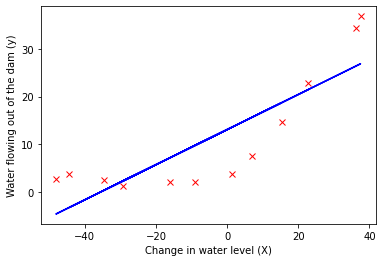

In [10]:
# Pintado de las gráficas
draw_graph(X, y, X, X_1)

## Parte 2 - Curvas de aprendizaje

Ahora vamos a identificar situaciones de sesgo y varianza. Para ello vamos a repetir el entrenamiento pero con subconjuntos de datos de entrenamiento. 

In [11]:
# Función que devuelve el coste y el gradiente
def cost_and_gradient(Thetas, X, y, lam):
    coste = cost_reg(Thetas, X, y, lam)
    gradiente = gradient_reg(Thetas, X, y, lam)
    return coste, gradiente

In [12]:
# Función que calcula la curva de aprendizaje
def learning_curve(X, y, Xval, yval, lam):
    
    Thetas = np.zeros(np.shape(X)[1])
    
    # Arrays de errores 
    erroresX = np.zeros((X.shape[0],))
    erroresXval = np.zeros((X.shape[0],))
    
    # Cálculo del error para distinta cantidad de datos de entrenamiento
    for i in range(X.shape[0]):
        ejemplaresX = X[0:i+1]
        ejemplaresy = y[0:i+1]
        
        #result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(ejemplaresX, ejemplaresy, lam))[0]
        result = opt.minimize(fun=cost_and_gradient, x0=Thetas, 
                              args=(ejemplaresX, ejemplaresy, lam), 
                              method='TNC', jac=True, options ={'maxiter': 2000})['x']
        
        erroresX[i] = cost_reg(result, ejemplaresX, ejemplaresy, lam)
        erroresXval[i] = cost_reg(result, Xval, yval, lam)
    
    return erroresX, erroresXval

In [13]:
# Función que dibuja la curva de aprendizaje
def draw_curve_graph(X, erroresX, erroresXval):
    ejeX = range(1, X.shape[0]+1)
    plt.figure()
    plt.plot(ejeX, erroresX, 'b', label = "Entrenamiento")
    plt.plot(ejeX, erroresXval, 'orange', label = "Validacion")
    plt.xlabel("Cantidad de ejemplos de entrenamiento")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

### Observando resultados

Como podemos observar, con pocos ejemplos de entrenamiento, el error del conjunto de entrenamiento es 0, pero el de validación es muy alto. Sin embargo, a medida que vamos subiendo el número de ejemplos, el error de los ejemplos de validación baja.

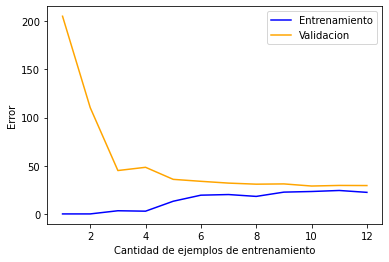

In [14]:
# Se añade una columna de 1's sobre los ejemplos de validación
Xval_1 = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

# Cálculo de errores
erroresX, erroresXval = learning_curve(X_1, y, Xval_1, yval, 0)

# Pintado de gráficas
draw_curve_graph(X, erroresX, erroresXval)

## Parte 3 - Regresion polinomial

Para que nuestro modelo se ajuste con mejor precisión a los datos, vamos a generar nuevos datos de entrenamiento sobre los datos originales. Esto se consigue realizando operaciones polinómicas sobre los datos, aunque hay que ser consciente de que habrá diferencias de rango, por lo que también debemos normalizar.

In [15]:
# Genera el polinomio
def make_data(X, grado):
    poly = PolynomialFeatures(grado)
    X = poly.fit_transform(X)
    return X

In [16]:
# Normalización con StandardScaler
def normalizar(X):
    Scaler = StandardScaler()
    X = Scaler.fit_transform(X)
    mu = Scaler.mean_
    sigma = Scaler.scale_
    return X, mu, sigma

### Observando resultados

In [17]:
# Inicialización de los datos
X_poly = make_data(X, 8)
X_poly[:, 1:], mu, sigma = normalizar(X_poly[:, 1:])
Thetas = np.ones(X_poly.shape[1])

# Regresión lineal
result = opt.fmin_tnc(func=cost_reg, x0=Thetas, fprime=gradient_reg, args=(X_poly, y, 0))

In [18]:
# Predicciones sobre nuevos valores de x
X_evaluate = np.arange(X.min() - 4, X.max() + 4, 0.05)
X_evaluate = X_evaluate.reshape(-1, 1)
X_evaluate_poly = make_data(X_evaluate, 8)
X_evaluate_poly[:, 1:] = (X_evaluate_poly[:, 1:] - mu)/sigma

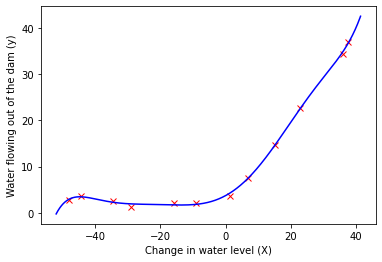

In [19]:
# Pintado de las gráficas
draw_graph(X, y, X_evaluate, X_evaluate_poly)

### Curvas de aprendizaje

In [20]:
# Normalizamos en función de mu y sigma anteriores
Xval_poly = make_data(Xval, 8)
Xval_poly[:, 1:] = (Xval_poly[:, 1:] - mu)/sigma

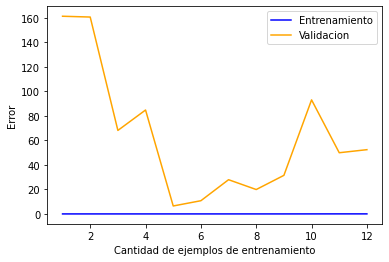

In [21]:
# Curva de aprendizaje para lambda = 0
lam = 0

# Cálculo de errores
erroresX, erroresXval = learning_curve(X_poly, y, Xval_poly, yval, lam)

# Pintado de gráficas
draw_curve_graph(X, erroresX, erroresXval)

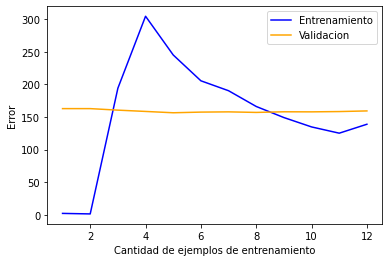

In [22]:
# Curva de aprendizaje para lambda = 100
lam = 100 

# Cálculo de errores
erroresX, erroresXval = learning_curve(X_poly, y, Xval_poly, yval, lam)

# Pintado de gráficas
draw_curve_graph(X, erroresX, erroresXval)

## Parte 4 - Selección del parámetro λ

Vamos a calcular cual es el mejor valor posible para . Para ello, vamos a generar distintos valores del parámetro, entrenaremos el modelo sonbre un conjunto de valores y lo evaluaremos sobre un conjunto de ejemplos de validación.

In [27]:
# Función que evalua la hipótesis sobre distintos valores de lambda 
def lambda_evaluation(X, y, Xval, yval, p, lambdas):
    
    # Arrays de errores 
    erroresX = np.zeros((len(lambdas),))
    erroresXval = np.zeros((len(lambdas),))

    # Array de thetas
    thetas = np.zeros(p+1)

    # Entrenamiento
    for i, l in enumerate(lambdas):  
        result = opt.minimize(fun=cost_reg, x0=thetas, args=(X, y, l))['x']
        erroresX[i] = cost_reg(result, X, y, 0)
        erroresXval[i] = cost_reg(result, Xval, yval, 0)
        print("Lambda: ", l, "\t ErrorTrain: ", erroresX[i], "\t ErrorVal: ", erroresXval[i])
    
    return erroresX, erroresXval

In [28]:
# Función que dibuja la gráfica
def draw_lambda_graph(lambdas, erroresX, erroresXVal):
    plt.figure()
    plt.plot(np.ravel(lambdas), erroresX, 'b', label = "Entrenamiento")
    plt.plot(np.ravel(lambdas), erroresXVal, 'orange', label = "Validacion")
    plt.xlabel("λ")
    plt.ylabel("Error")
    plt.legend(loc = 0)
    plt.show()

### Observando resultados

In [29]:
# Inicialización de p y lambdas
p = 8
lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

# Inicialización de los datos
X_poly = make_data(X, p)
X_poly[:, 1:], mu, sigma = normalizar(X_poly[:, 1:])

# Normalizamos en función de mu y sigma anteriores
Xval_poly = make_data(Xval, p)
Xval_poly[:, 1:] = (Xval_poly[:, 1:] - mu)/sigma

# Cálculo del error
erroresX, erroresXval = lambda_evaluation(X_poly, y, Xval_poly, yval, 8, lambdas)

Lambda:  0 	 ErrorTrain:  0.02889052005433446 	 ErrorVal:  54.09138292223895
Lambda:  0.001 	 ErrorTrain:  0.10797940331958822 	 ErrorVal:  9.35818845158914
Lambda:  0.003 	 ErrorTrain:  0.16678838641659088 	 ErrorVal:  15.919311669751588
Lambda:  0.01 	 ErrorTrain:  0.21795185762073532 	 ErrorVal:  17.148918726205842
Lambda:  0.03 	 ErrorTrain:  0.27515037572455164 	 ErrorVal:  13.215396787664462
Lambda:  0.1 	 ErrorTrain:  0.4386584089419957 	 ErrorVal:  7.9263867825831165
Lambda:  0.3 	 ErrorTrain:  0.8681677982172851 	 ErrorVal:  4.760823382309178
Lambda:  1 	 ErrorTrain:  1.9586901971292128 	 ErrorVal:  4.263355872696739
Lambda:  3 	 ErrorTrain:  4.525106777836854 	 ErrorVal:  3.8321766807381152
Lambda:  10 	 ErrorTrain:  14.82577683208397 	 ErrorVal:  8.889695910207056


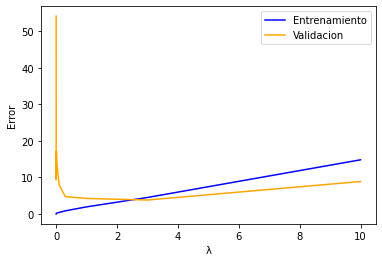

In [30]:
# Pintado de la gráfica
draw_lambda_graph(lambdas, erroresX, erroresXval)

El mejor valor de λ parece ser 3. Ahora vamos a estimar el error sobre un conjunto de ejemplos que no hayamos utilizado ni para entrenar, ni para seleccionar λ.

In [36]:
# Normalizamos en función de mu y sigma anteriores
Xtest_poly = make_data(Xtest, p)
Xtest_poly[:, 1:] = (Xtest_poly[:, 1:] - mu)/sigma

# Entrenamiento
thetas = np.zeros(p+1)
result = opt.minimize(fun=cost_reg, x0=thetas, args=(X_poly, y, 3))['x']

# Resultado (debe salir 3,572)
print("Lambda: 3\t", "ErrorTest: ", cost_reg(result, Xtest_poly, ytest, 0))

Lambda: 3	 ErrorTest:  3.572027276614662
